In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
import jax

import numpy as np

# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

plt.style.use('seaborn')

# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

In [19]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
##############################################################################

# CONSTANTS
FILE_PATH = 'edges.txt'
NUM_VARS = 3

WEIGHT_ODOMETRY = 100
WEIGHT_LOOP_CLOSURE = 500
WEIGHT_ANCHOR = 1000


LM_LAMBDA = 1
NUM_ITERS = 1000
TOL = 1e-6

In [20]:
# UTILITY FUNCTIONS

def read_vertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def read_edge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

# plot trajectory using matplotlib
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()
    
# motion model
def next_pose(x, y, theta, del_x, del_y, del_theta):
    x_new = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)
    y_new = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
    theta_new = theta + del_theta
    return jnp.array([x_new, y_new, theta_new])

Poses (Vertices): (120, 3)


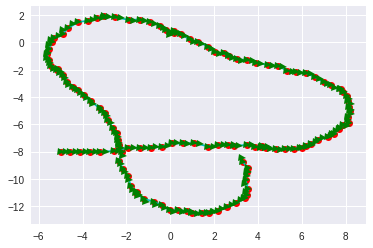

In [21]:
# READ INPUT FILE AND GENERATE POSES

vertex = read_vertex(FILE_PATH)
edges = read_edge(FILE_PATH)
x = vertex[0][0]
y = vertex[1][0]
theta = vertex[2][0]

poses = []
poses.append(jnp.array([x, y, theta]))

for i in range(edges[0].shape[0]):
    ind1 = edges[0][i]
    ind2 = edges[1][i]
    
    if(abs(ind2 - ind1) > 1):
        break # do not include loop closure constrains
    
    del_x = edges[2][i]
    del_y = edges[3][i]
    
    del_theta = edges[4][i]
    
    x, y, theta = next_pose(x, y, theta, del_x, del_y, del_theta) # use odometry to get the next pose
    poses.append(jnp.array([x, y, theta]))
    
poses = jnp.array(poses)
print('Poses (Vertices):', poses.shape)
draw(poses[:,0], poses[:,1], poses[:,2])

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [22]:
# KEY FUNCTIONS

# Order of edges:
## x_anchor
## y_anchor
## theta_anchor
## for every edge:
### x_i
### y_i
### theta_i

# Order of pose variables
## for every edge:
### x_i
### y_i
### theta_i

def derivative_with_initial(x_i, y_i, theta_i, x_f, y_f, theta_f, del_x, del_y, del_theta):
    result = jnp.eye(NUM_VARS)
    
    result = jax.ops.index_update(result, jax.ops.index[0, 2], - del_x * jnp.sin(theta_i) - del_y * jnp.cos(theta_i))    
    result = jax.ops.index_update(result, jax.ops.index[1, 2], - del_y * jnp.sin(theta_i) + del_x * jnp.cos(theta_i))
    return result
    
def derivative_with_final(x_i, y_i, theta_i, x_f, y_f, theta_f, del_x, del_y, del_theta):
    result = -1 * jnp.eye(NUM_VARS)
    return result

def information_matrix(edges, weight_odom, weight_loop, weight_anchor):
    # edge x edge matrix
    diagonal = []
    
    # anchor edge
    diagonal.extend([weight_anchor] * NUM_VARS)
    
    for i in range(edges[0].shape[0]):
        ind1 = edges[0][i]
        ind2 = edges[1][i]
        if abs(ind2 - ind1) == 1:
            # odom edges
            diagonal.extend([weight_odom] * NUM_VARS)
        else:
            # loop closure edges
            diagonal.extend([weight_loop] * NUM_VARS)
    
    return jnp.diag(jnp.array(diagonal))

def residual(current_poses, edges):
    residue = []
    
    # anchor edges
    residue.extend(list(current_poses[0] - 0))
    
    # other edges
    for i in range(edges[0].shape[0]):
        ind1 = edges[0][i]
        ind2 = edges[1][i]
        
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        
        estimated_pose_2 = next_pose(*current_poses[ind1], del_x, del_y, del_theta)
        diff = list(estimated_pose_2 - current_poses[ind2])
        residue.extend(diff)
    
    return jnp.asarray(residue)

# res = residual(poses, edges)
# print(res.shape)
# weights = information_matrix(edges, WEIGHT_ODOMETRY, WEIGHT_LOOP_CLOSURE, WEIGHT_ANCHOR)
# print(weights[2])

def jacobian(current_poses, edges):
    num_constraints = (edges[0].shape[0] * NUM_VARS) + NUM_VARS # for anchor edges
    num_variables = current_poses.shape[0] * NUM_VARS
    
    # constraints are ordered as in `edges`
    # variables are ordered as in `current_poses`
    
    J = jnp.zeros((num_constraints, num_variables))
    
    # for anchor edges
    J = jax.ops.index_update(J, jax.ops.index[:NUM_VARS, :NUM_VARS], np.eye(NUM_VARS))
    
    # for other edges
    for i in range(edges[0].shape[0]):
        ind1 = edges[0][i]
        ind2 = edges[1][i]
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        
        J = jax.ops.index_update(
                J,
                jax.ops.index[NUM_VARS + i * NUM_VARS:NUM_VARS + i * NUM_VARS + NUM_VARS, ind1 * NUM_VARS: ind1 * NUM_VARS + NUM_VARS],
                derivative_with_initial(*poses[ind1], *poses[ind2], del_x, del_y, del_theta)
            )
        
        J = jax.ops.index_update(
                J,
                jax.ops.index[NUM_VARS + i * NUM_VARS:NUM_VARS + i * NUM_VARS + NUM_VARS, ind2 * NUM_VARS: ind2 * NUM_VARS + NUM_VARS],
                derivative_with_final(*poses[ind1], *poses[ind2], del_x, del_y, del_theta)
            )
    
    return J

def get_error(poses, edges, weights):
    f = residual(poses, edges)
    # J = jacobian(poses, edges)
    return 0.5 * f.T @ weights @ f

def step_lm(poses, edges, weights, lamda):
    f = residual(poses, edges)
    J = jacobian(poses, edges)
    
    step = - jnp.linalg.inv(J.T @ weights @ J + lamda * jnp.eye(J.shape[1])) @ J.T @ weights.T @ f
    return step.reshape((-1, NUM_VARS))

In [23]:
# plot trajectory using matplotlib
def draw_traj(X, Y, THETA):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    
    gt_poses = read_vertex('gt.txt')
    gt_poses = gt_poses.T
    
    # Plot Ground truth
    ax[0].set_title("Ground Truth")
    ax[0].plot(gt_poses[:,0], gt_poses[:,1], 'ro')
    ax[0].plot(gt_poses[:,0], gt_poses[:,1], 'c-')
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(gt_poses[i][3]) + gt_poses[i][0]
        y2 = 0.25*math.sin(gt_poses[i][3]) + gt_poses[i][1]
        ax[0].plot([gt_poses[i][0], x2], [gt_poses[i][1], y2], 'g->')
    
    # Plot Initial estimate
    ax[1].set_title("Initial Estimate")
    ax[1].plot(poses[:,0], poses[:,1], 'ro')
    ax[1].plot(poses[:,0], poses[:,1], 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(poses[i][3]) + poses[i][0]
        y2 = 0.25*math.sin(poses[i][3]) + poses[i][1]
        ax[1].plot([poses[i][0], x2], [poses[i][1], y2], 'g->')
    
    # Plot optimised trajectory
    ax[2].set_title("Optimised Trajectory")
    ax[2].plot(X, Y, 'ro')
    ax[2].plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        ax[2].plot([X[i], x2], [Y[i], y2], 'g->')
    plt.show()
    
    
def optimise_lm(poses, edges, num_iters=NUM_ITERS, lamda=LM_LAMBDA, tol=TOL):
    weights = information_matrix(edges, WEIGHT_ODOMETRY, WEIGHT_LOOP_CLOSURE, WEIGHT_ANCHOR)
    
    poses_history = [poses]
    errors_history = [get_error(poses, edges, weights), ]

    print('Initial Guess')
    draw_traj(poses[:, 0], poses[:, 1], poses[:, 2])
    
    for _ in range(num_iters):
        new_poses = poses + step_lm(poses, edges, weights, lamda)
        new_error = get_error(new_poses, edges, weights)
        print('ITER', _, 'ERROR', new_error)
        if _ % 10 == 0:
            draw_traj(new_poses[:, 0], new_poses[:, 1], new_poses[:, 2])

        if len(errors_history) > 0:
            if (new_error > errors_history[-1]):
                lamda = lamda * 2
            else:
                lamda = lamda / 3
                
        errors_history.append(new_error)
        poses_history.append(new_poses)
        
        if np.linalg.norm(new_poses - poses) < tol:
            break
        poses = new_poses
        
    return poses_history, errors_history

Initial Guess


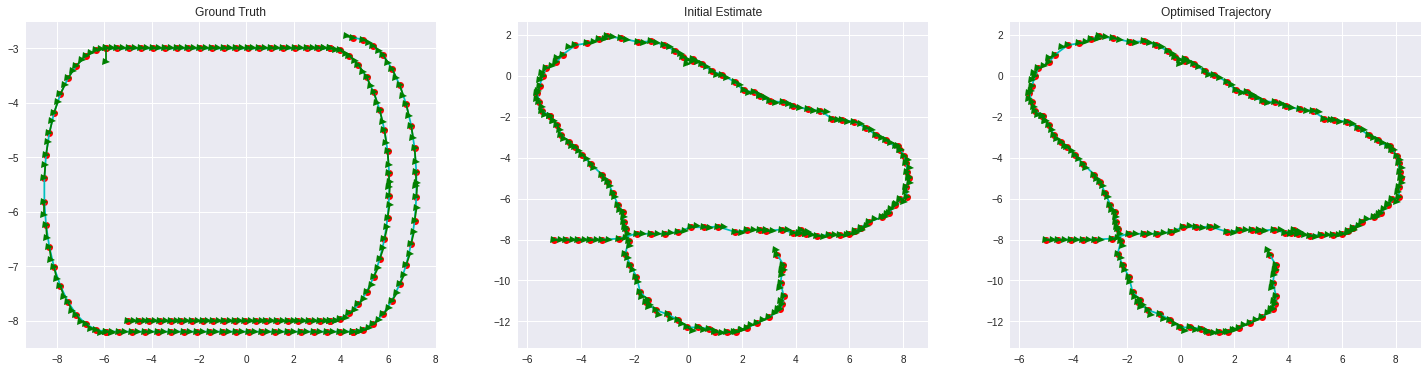

ITER 0 ERROR 62680.492


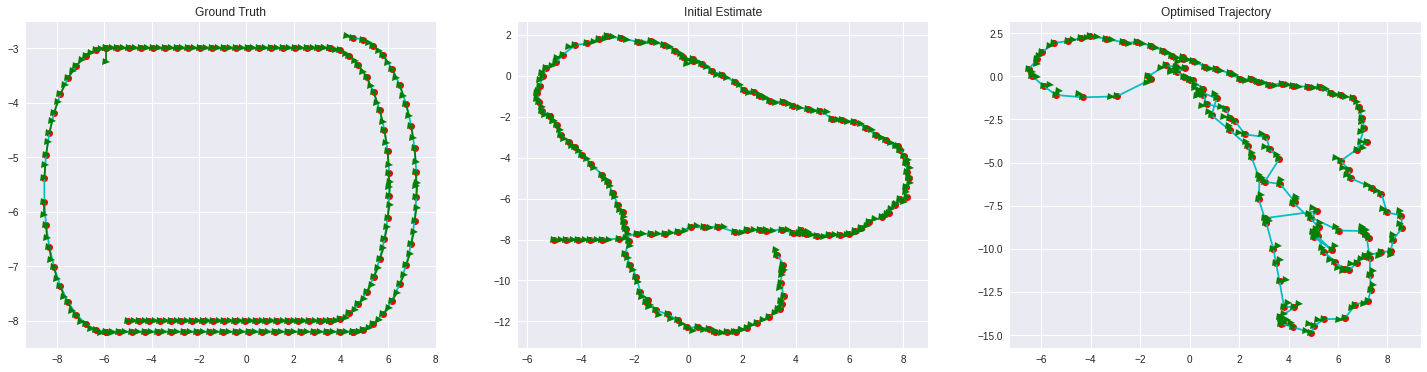

ITER 1 ERROR 5150.45
ITER 2 ERROR 6356.3477
ITER 3 ERROR 3495.0342
ITER 4 ERROR 761.8815
ITER 5 ERROR 1585.4181
ITER 6 ERROR 1437.5448
ITER 7 ERROR 1066.1104
ITER 8 ERROR 730.22125
ITER 9 ERROR 649.9115
ITER 10 ERROR 674.209


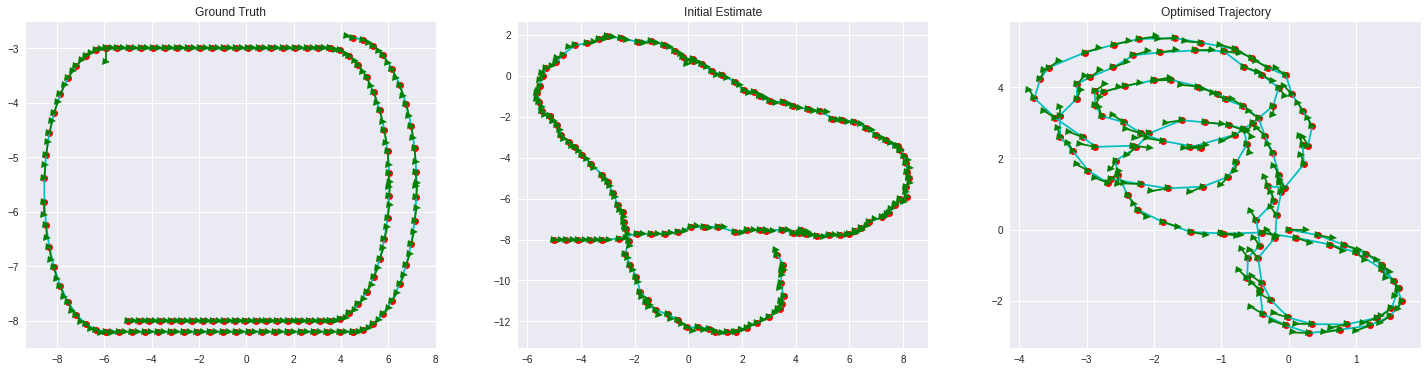

ITER 11 ERROR 748.33234
ITER 12 ERROR 850.3014
ITER 13 ERROR 971.1724
ITER 14 ERROR 1155.9818
ITER 15 ERROR 1693.6577
ITER 16 ERROR 3373.4417
ITER 17 ERROR 5809.532
ITER 18 ERROR 3186.7192
ITER 19 ERROR 362.29974
ITER 20 ERROR 259.0671


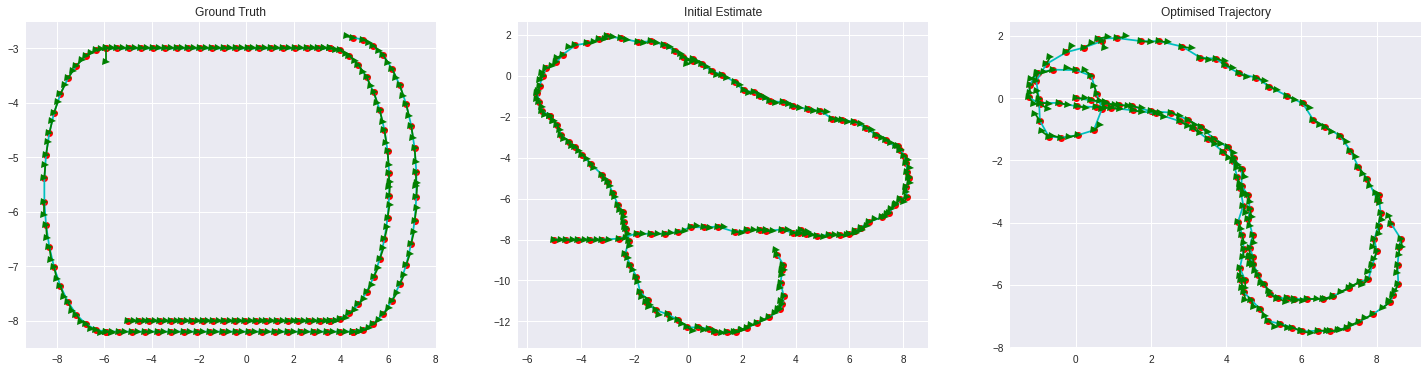

ITER 21 ERROR 238.49979
ITER 22 ERROR 186.5737
ITER 23 ERROR 167.16008
ITER 24 ERROR 162.34346
ITER 25 ERROR 162.09453
ITER 26 ERROR 162.34499
ITER 27 ERROR 161.3498
ITER 28 ERROR 158.5645
ITER 29 ERROR 154.02016
ITER 30 ERROR 148.5875


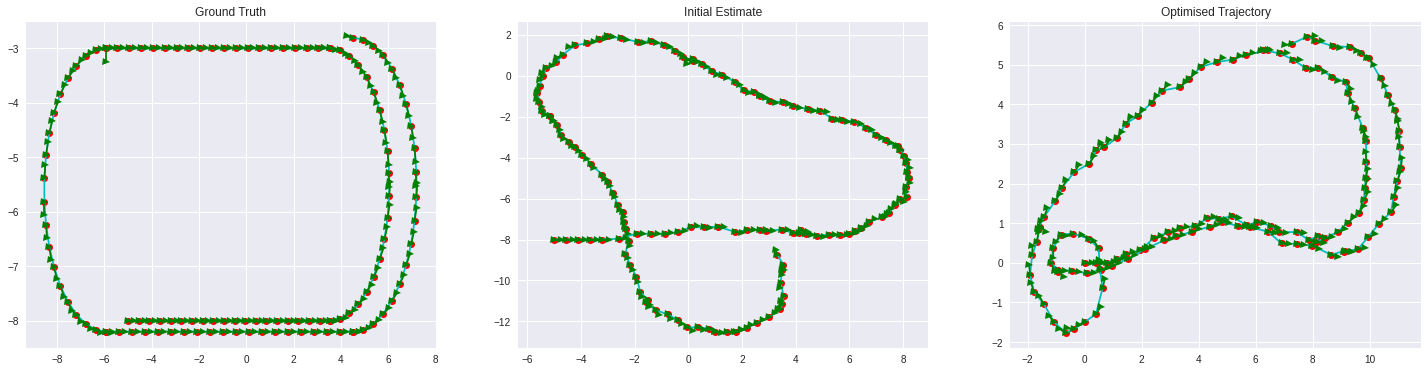

ITER 31 ERROR 143.39713
ITER 32 ERROR 139.3359
ITER 33 ERROR 136.69417
ITER 34 ERROR 135.29492
ITER 35 ERROR 134.93054
ITER 36 ERROR 135.54657
ITER 37 ERROR 136.95813
ITER 38 ERROR 138.48093
ITER 39 ERROR 139.0682
ITER 40 ERROR 138.1113


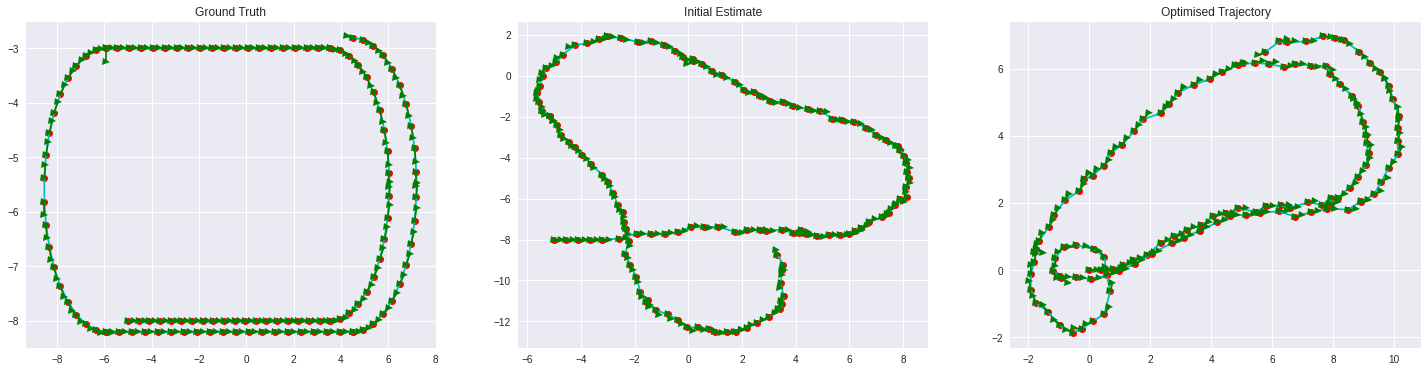

ITER 41 ERROR 136.23248
ITER 42 ERROR 134.84142
ITER 43 ERROR 134.3312
ITER 44 ERROR 133.38298
ITER 45 ERROR 131.35886
ITER 46 ERROR 130.67688
ITER 47 ERROR 135.04471
ITER 48 ERROR 145.06857
ITER 49 ERROR 155.62296
ITER 50 ERROR 158.22375


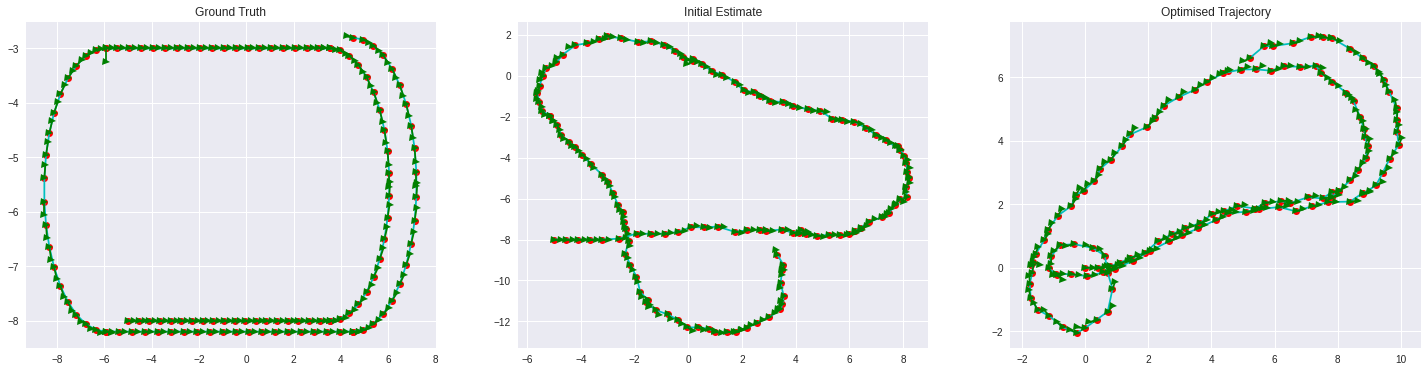

ITER 51 ERROR 150.55109
ITER 52 ERROR 146.79616
ITER 53 ERROR 163.78598
ITER 54 ERROR 183.2485
ITER 55 ERROR 170.52078
ITER 56 ERROR 140.51958
ITER 57 ERROR 140.20874
ITER 58 ERROR 198.18143
ITER 59 ERROR 315.04895
ITER 60 ERROR 451.5711


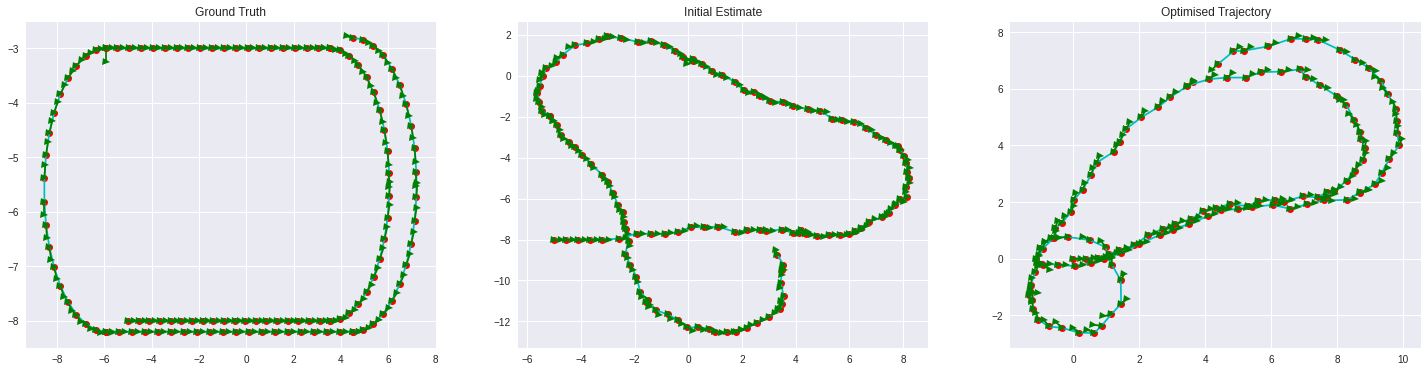

ITER 61 ERROR 495.0739
ITER 62 ERROR 335.60382
ITER 63 ERROR 306.7938
ITER 64 ERROR 915.7792
ITER 65 ERROR 1110.4584
ITER 66 ERROR 548.94
ITER 67 ERROR 240.33708
ITER 68 ERROR 278.92224
ITER 69 ERROR 676.24756
ITER 70 ERROR 1688.2222


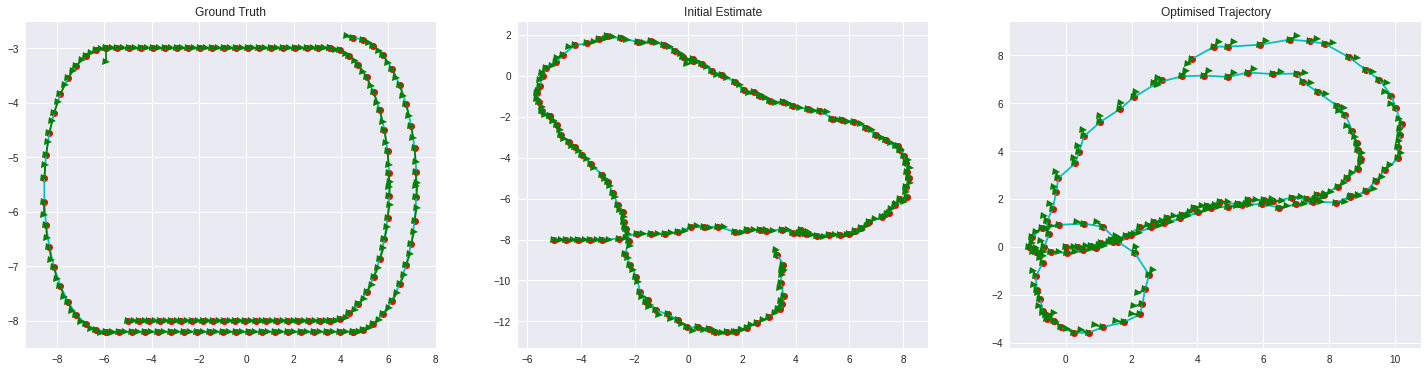

ITER 71 ERROR 3963.983
ITER 72 ERROR 7493.628
ITER 73 ERROR 6785.7363
ITER 74 ERROR 2566.7197
ITER 75 ERROR 1931.9478
ITER 76 ERROR 2130.3853
ITER 77 ERROR 2174.7896
ITER 78 ERROR 1246.1035
ITER 79 ERROR 1856.8999
ITER 80 ERROR 2423.9827


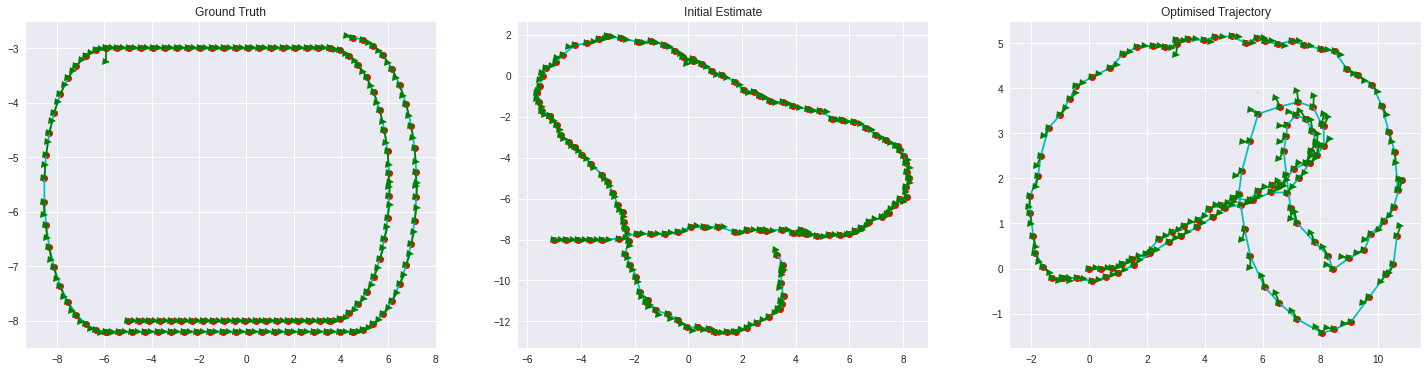

ITER 81 ERROR 2280.4868
ITER 82 ERROR 1657.5999
ITER 83 ERROR 984.25134
ITER 84 ERROR 498.26385
ITER 85 ERROR 264.59244
ITER 86 ERROR 189.1127
ITER 87 ERROR 170.87418
ITER 88 ERROR 166.86816
ITER 89 ERROR 165.87134
ITER 90 ERROR 165.51268


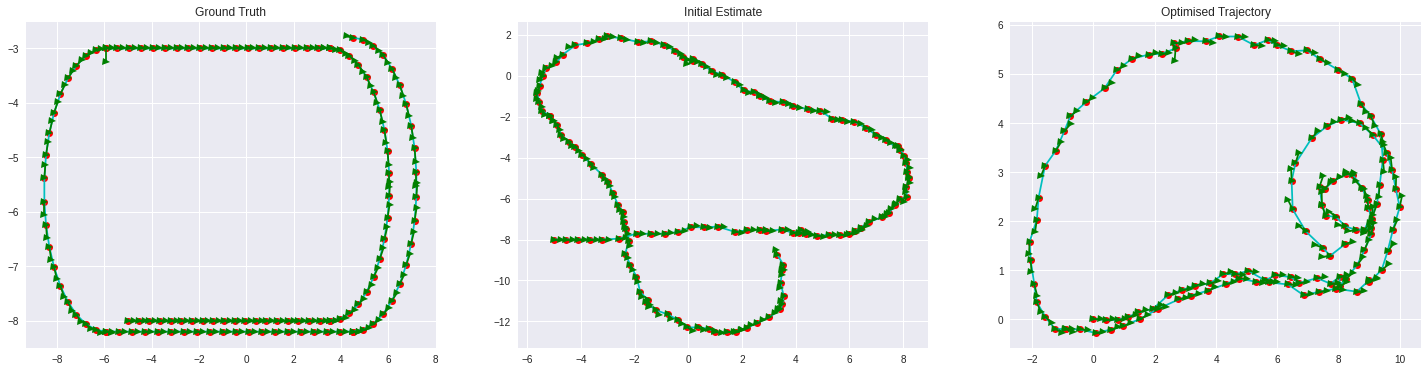

ITER 91 ERROR 165.31616
ITER 92 ERROR 165.18677
ITER 93 ERROR 165.10036
ITER 94 ERROR 165.04428
ITER 95 ERROR 165.00883
ITER 96 ERROR 164.98723
ITER 97 ERROR 164.97437
ITER 98 ERROR 164.96701
ITER 99 ERROR 164.96304


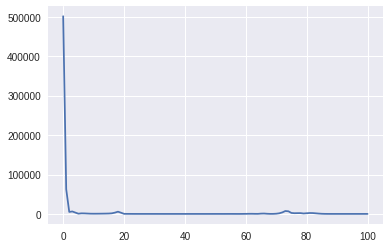

130.67688


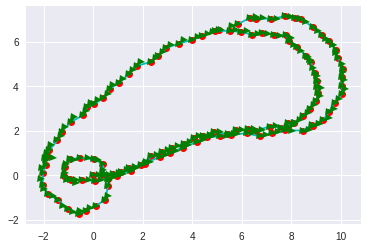

TypeError: ignored

In [24]:
%%time
poses_history, errors_history = optimise_lm(poses, edges, num_iters=100)
plt.plot(errors_history)
plt.show()
best = jnp.argmin(jnp.asarray(errors_history))
print(errors_history[best])
draw(poses_history[best][:, 0], poses_history[best][:, 1], poses_history[best][:, 2])
write_poses(poses_history[best], edges, 'opt.g2o')

In [25]:
def write_poses(poses,file_name):
    with open(file_name, 'w') as f:
        for i in range(poses.shape[0]):
            st = "VERTEX_SE2 " + str(i) + " " + str(poses[i][0]) + " " + str(poses[i][1]) + " " + str(poses[i][2])
            f.write("%s\n" % st)
        
        # write edges and FIX
        f2 = open('edges.txt', 'r')
        A = f2.readlines()
        f2.close()
        
        for line in A:
            if "VERTEX_SE2" not in line:
                f.write("%s" % line)

In [27]:
write_poses(poses_history[best], 'opt.g2o')